In [1]:
import pyaudio
import wave
import numpy as np

class GuitarInterface(object):
    
    def __init__(self, audio_device_name="JAM 96k", audio_format=pyaudio.paInt16, channels=1, rate=44100,
                 chunk_size=1024):
        
        # Store some values that we'll need easy access to
        self.audio_format = audio_format
        self.channels = channels
        self.rate = rate
        self.chunk_size = chunk_size
        
        # Initialize the Audio library and device
        self.audio = pyaudio.PyAudio()
        self.audio_device_id = [i for i in range(self.audio.get_device_count()) if self.audio.get_device_info_by_index(i)['name'] == audio_device_name][0]
    
    """
        Capture a number of seconds worth of audio input from the pyAudio device initialized.
        Returns:
            SoundSample: representing the audio captured
    """
    def capture_audio(self, secs=5):
        stream = self.audio.open(format=self.audio_format, channels=self.channels, rate=self.rate, input=True,
                                input_device_index=self.audio_device_id, frames_per_buffer=self.chunk_size)

        frames = stream.read(self.rate * secs)
        
        # stop Recording and properly close the stream
        stream.stop_stream()
        stream.close()
        #self.audio.terminate()
        return SoundSample(frames)
    
    """
        Save a .wav file that can be played back from a SoundSample - 
        Should be saved with the same audio interface that it was created with (so datatypes match)
        
    """
    def save_byte_frames(self, sound_sample, output_filename="audio_output.wav"):
        
        print ("Saving audio sample to: {}".format(output_filename))
        waveFile = wave.open(output_filename, 'wb')
        waveFile.setnchannels(self.channels)
        waveFile.setsampwidth(self.audio.get_sample_size(self.audio_format))
        waveFile.setframerate(self.rate)
        waveFile.writeframes(b''.join(sound_sample.asByteList))
        waveFile.close()
        print("Finished writing file.")
        
        
# A small class to wrap up some useful sound sample conversion methods
# This class doesn't cache the generated lists - this might be a useful optimization at Train time.
class SoundSample(object):
    
    def __init__(self, sample_stream, np_datatype='Int16'):
        self.np_datatype = np_datatype
        self.sample_stream = sample_stream
        
    @property
    def stream(self):
        return self.sample_stream
    
    @property
    def asList(self):
        data = np.fromstring(self.sample_stream, self.np_datatype)
        return data
    
    @property
    def asByteList(self):
        return [a for a in self.sample_stream]


In [5]:
# Yay - looks like this simple test works - next we should do some simple plotting and get a waveform perhaps for the audio

g_int = GuitarInterface()
sound_sample = g_int.capture_audio(secs=4)
print("Saved a short sample: {} frames".format(len(sound_sample.stream)))

# Let's try saving the audio to a file ->
g_int.save_byte_frames(sound_sample, "my_second_output.wav")

Saved a short sample: 352800 frames
Saving audio sample to: my_second_output.wav
Finished writing file.


In [2]:
# Time to generate the Train and Test Sets
# For training let's go through the notes twice, and for testing, let's do it just once - so three times in all
data_key = ['Low_C', 'D', 'E', 'F', 'G', 'A', 'B', 'High_C']
data_audio = [[] for _ in range(8)]

gi = GuitarInterface()

for sample_set in range(3):
    for i, note in enumerate(data_key):
        raw_input("Press Enter and then record a {}".format(note))
        
        sample = gi.capture_audio(secs=3)
        data_audio[i].append(sample)
        
        # We're also going to save a copy of the data - so we don't have to repeat this process
        gi.save_byte_frames(sample, "monophonic_data/{}_{}.wav".format(note, sample_set))
        
# We should also record a reference for white noise - so let's record nothing at all
raw_input("Let's also record a reference clip for white noise - press enter, but don't play anything")
sample = gi.capture_audio(secs=3)
white_noise = sample
gi.save_byte_frames(sample, "monophonic_data/white_noise.wav")

print("Great - all set with the recording!")

Press Enter and then record a Low C
Saving audio sample to: monophonic_data/Low C_0.wav
Finished writing file.
Press Enter and then record a D
Saving audio sample to: monophonic_data/D_1.wav
Finished writing file.
Press Enter and then record a E
Saving audio sample to: monophonic_data/E_2.wav
Finished writing file.
Press Enter and then record a F
Saving audio sample to: monophonic_data/F_3.wav
Finished writing file.
Press Enter and then record a G
Saving audio sample to: monophonic_data/G_4.wav
Finished writing file.
Press Enter and then record a A
Saving audio sample to: monophonic_data/A_5.wav
Finished writing file.
Press Enter and then record a B
Saving audio sample to: monophonic_data/B_6.wav
Finished writing file.
Press Enter and then record a High C
Saving audio sample to: monophonic_data/High C_7.wav
Finished writing file.
Press Enter and then record a Low C
Saving audio sample to: monophonic_data/Low C_0.wav
Finished writing file.
Press Enter and then record a D
Saving audio sa

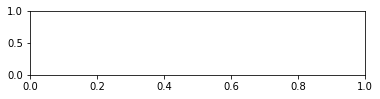

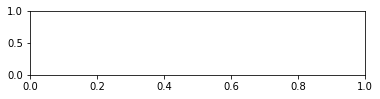

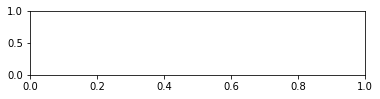

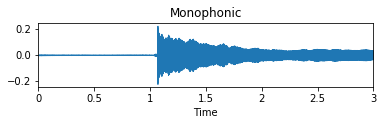

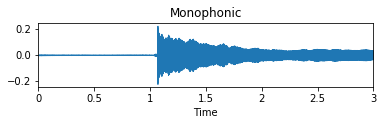

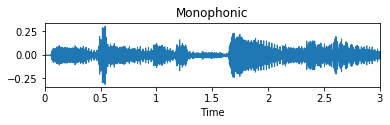

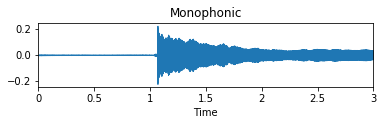

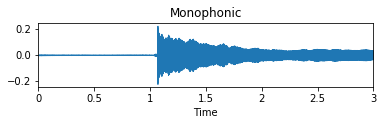

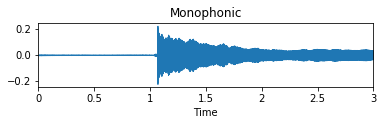

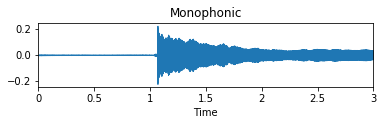

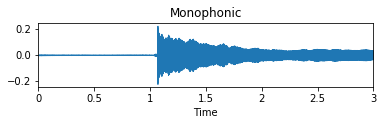

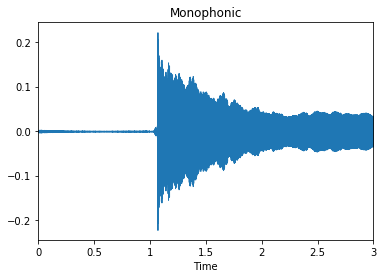

In [15]:
# data_key -> key of note names
# data_audio -> audio recording (SoundSamples)

# Let's try loading one of the samples with librosa
import matplotlib.pyplot as plt
import librosa
import librosa.display

filepath = "monophonic_data/A_5.wav"
y, sr = librosa.load(filepath, duration=3)
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('Monophonic')
plt.show()

/Users/raymondklass/anaconda2/lib/python2.7/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


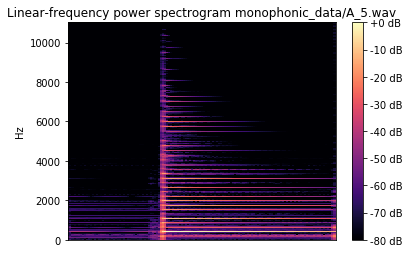

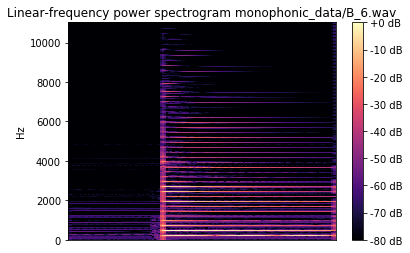

In [16]:
# Let's try visualizing the spectrum plot
filepath1 = "monophonic_data/A_5.wav"
filepath2 = "monophonic_data/B_6.wav"

for fp in [filepath1, filepath2]:
    y, sr = librosa.load(fp)
    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Linear-frequency power spectrogram {}".format(fp))
    plt.show()

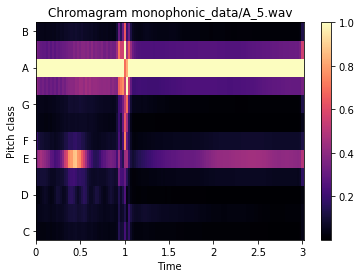

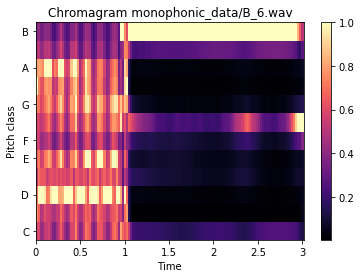

In [18]:
# Explore Chroma SFTP features

for fp in [filepath1, filepath2]:
    y, sr = librosa.load(fp)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title("Chromagram {}".format(fp))
    plt.show()


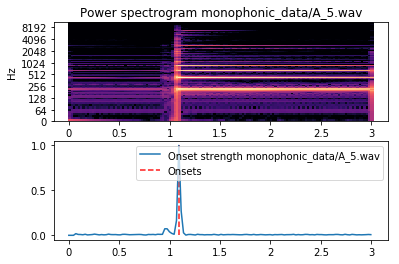

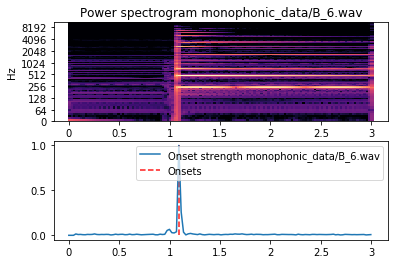

In [22]:
# let's play around with onset detection
for fp in [filepath1, filepath2]:
    y, sr = librosa.load(fp)
    
    o_env = librosa.onset.onset_strength(y, sr=sr)
    times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
    onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)
    
    D = librosa.stft(y)
    plt.figure()
    ax1 = plt.subplot(2, 1, 1)
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                              x_axis='time', y_axis='log')
    plt.title("Power spectrogram {}".format(fp))
    plt.subplot(2, 1, 2, sharex=ax1)
    plt.plot(times, o_env, label="Onset strength {}".format(fp))
    plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
               linestyle='--', label='Onsets')
    plt.axis('tight')
    plt.legend(frameon=True, framealpha=0.75)
    plt.show()
    